### ДЗ 13
#### Козел А.Г. v.2
6.11-14.11

Не менее 20000 символов.
уменьшить размерность текста, используя метод главных компонент, при этом обеспечить сохранение информации не менее 80%


### Задачи:

- осуществить загрузку текста, токенизацию

- почистить данные (числа, знаки препинания, символы, стоп-слова)

- осуществить лемматизацию

- перевести в векторное представление

- применить метод главных компонент таким образом, чтобы потеря информации составила не более 20%

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

- (если есть метки классов) посчитать результаты обучения. 


In [34]:
# Загрузка требуемых библиотек
import numpy as np
import pandas as pd
import re
import string
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from gensim.models import Word2Vec
import spacy 
from spacy.lang.ru.stop_words import STOP_WORDS
import ru_core_news_sm
nlp = spacy.load("ru_core_news_sm")
import matplotlib.pyplot as plt

from string import punctuation
import gc

### Загрузка текста. Чистка данных. Лемматизация

In [2]:
with open('text.txt', encoding="utf8") as f:
    text = f.read()

In [3]:
book_result = re.sub(r'\d+', '', text)
doc = nlp(book_result)
# Лемматизация и конвертация токенов в нижний регистр
text_lemm = [ word.lemma_.lower().strip()
             if word.lemma_ != "-PRON-" 
             else word.lower_ for word in doc]
punctuations = string.punctuation + '–' # к списку пунктуации добавляю тире
#цикл проверяет не является ли слово в документе стоп-словом или знаком пунктуации
text_result = [word for word in text_lemm
               if word not in STOP_WORDS 
               and word not in punctuations]

count_words = Counter(text_result)
    
print('Количество слов в тексте: ' '{}.'.format(len(text_result)))
print('Количество уникальных слов в тексте: ' '{}.\n'.format(len(count_words)))

Количество слов в тексте: 2687.
Количество уникальных слов в тексте: 926.



In [4]:
count_words.most_common(5)

[('основание', 117),
 ('упругий', 75),
 ('модель', 70),
 ('пластина', 68),
 ('винклера', 36)]

### GloVe библиотека spaCy

In [7]:
df_words = pd.DataFrame.from_dict(count_words, 
                            orient='index').reset_index()
df_words = df_words.rename(columns={'index':'Word', 0:'Count'})
df_words.sort_values(by=['Count'], inplace=True, ascending=False)
df_words

,Word,Count
40,основание,117
39,упругий,75
52,модель,70
88,пластина,68
59,винклера,36
...,...,...
101,встречаться,1
499,включать,1
96,соседний,1
91,отдельный,1


In [8]:
def get_word_vectors(words):
    '''
    Функция конвертирует список слов в их векторное представление
    '''
    ar = []
    for i in words:
        ar.append(nlp(i).vector)
    return ar

word_vector_list = get_word_vectors(df_words['Word'])

In [9]:
df_vec = pd.DataFrame(word_vector_list)
df_vect = df_vec.T
df_vect.columns = df_words['Word']
df_vect.shape

(96, 926)

In [10]:
df_vect

Word,основание,упругий,модель,пластина,винклера,решение,пастернак,получить,работа,слой,...,гармонический,исчисление,расположенных,термический,графеновых,встречаться,включать,соседний,отдельный,упругих
0,0.951838,-0.088185,-0.630849,1.921225,0.034118,0.418325,1.297496,-1.080771,0.555174,0.136943,...,1.542111,0.530749,-1.525142,0.676455,-0.024778,-0.820209,0.082232,0.434203,0.821473,-0.936560
1,-0.892597,-0.613518,-0.759665,-1.043975,0.713835,-0.550014,-1.347244,0.760273,-0.294395,-0.140782,...,-0.358237,-1.405008,-0.542101,-0.321662,-0.529488,-0.342777,1.458805,-0.434951,-0.905283,-1.145408
2,-1.057502,-0.709338,-1.625736,-1.877834,-1.480577,-1.121727,0.756574,-0.106874,-1.099723,-0.995570,...,-0.162651,-0.230342,0.324435,-0.073257,-0.519278,-0.855596,-0.975202,0.849287,0.446600,0.022608
3,1.552870,1.193305,0.826858,-0.066129,0.337848,1.355503,-0.541379,0.167621,1.133619,-0.415360,...,-0.696407,1.832873,0.490612,0.173608,0.020524,1.808921,0.602928,0.202925,-1.622402,0.627983
4,0.287372,-0.597253,-0.567126,0.561594,-1.377479,0.721593,0.172674,-0.300918,-0.416031,-0.833982,...,1.896615,0.813829,2.206880,0.845079,2.392186,-0.078716,-0.134221,0.298406,1.588129,-0.375951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,1.067858,-0.360661,-0.127927,0.191870,-0.704468,1.744221,0.751622,-0.612005,0.176844,1.378864,...,-0.424749,0.954906,-0.304160,-0.492172,-0.284267,1.077399,-0.265830,-0.031946,0.118376,-0.127098
92,0.274829,0.861727,-0.703854,-1.718424,-0.129540,0.159675,0.711042,-1.032245,-1.384702,0.148713,...,0.765732,-0.295654,0.121436,0.472516,0.626010,-0.863535,-0.263696,0.192613,-0.420579,0.987958
93,0.244940,-0.942114,-0.926890,-0.232542,-0.351781,0.529519,-1.080944,0.359035,-1.123788,-2.052035,...,-0.282272,1.187534,-0.573079,-0.552165,-0.222579,1.475199,0.742073,-0.818091,-1.420596,0.168557
94,-0.427065,0.786915,-0.219642,0.605413,-1.029385,-0.859498,1.076980,0.017075,-0.091014,0.198544,...,-0.162161,-0.806623,0.523892,0.120976,0.658561,-1.119912,-0.020175,1.381226,-0.807480,-0.023377


In [11]:
gc.collect()

112

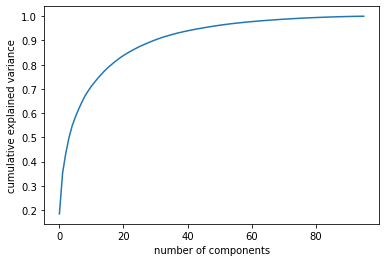

In [12]:
pca = PCA().fit(word_vector_list)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

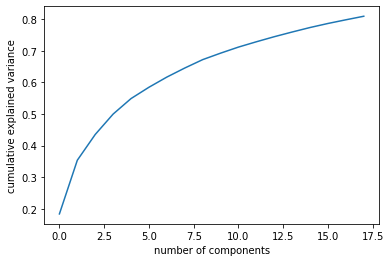

In [13]:
pca = PCA(0.8).fit(word_vector_list)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [14]:
words = df_words['Word'][:60]
print(list(words))

# Задаем 2 измерения
pca = PCA(n_components=2)
pca.fit(get_word_vectors(words))
word_vecs_2d = pca.transform(get_word_vectors(words))


['основание', 'упругий', 'модель', 'пластина', 'винклера', 'решение', 'пастернак', 'получить', 'работа', 'слой', 'исследовать', 'нагрузка', 'метод', 'толщина', 'колебание', 'численный', 'деформирование', 'рассмотреть', 'уравнение', 'расчёт', 'связать', 'конструкция', 'поверхность', 'изгиб', 'заполнитель', 'трехслойной', 'коэффициент', 'задача', 'анализ', 'случай', 'нелинейный', 'функция', 'статья', 'стержень', 'свойство', 'описание', 'сдвиг', 'полупространство', 'перемещение', 'выполнить', 'лежать', 'влияние', 'аналитический', 'прогиб', 'параметр', 'условие', 'гипотеза', 'использоваться', 'результат', 'грунт', 'математический', 'исследование', 'элемент', 'дифференциальный', 'ряд', 'многослойный', 'система', 'прямоугольный', 'свободный', 'вид']


In [15]:
gc.collect()

6485

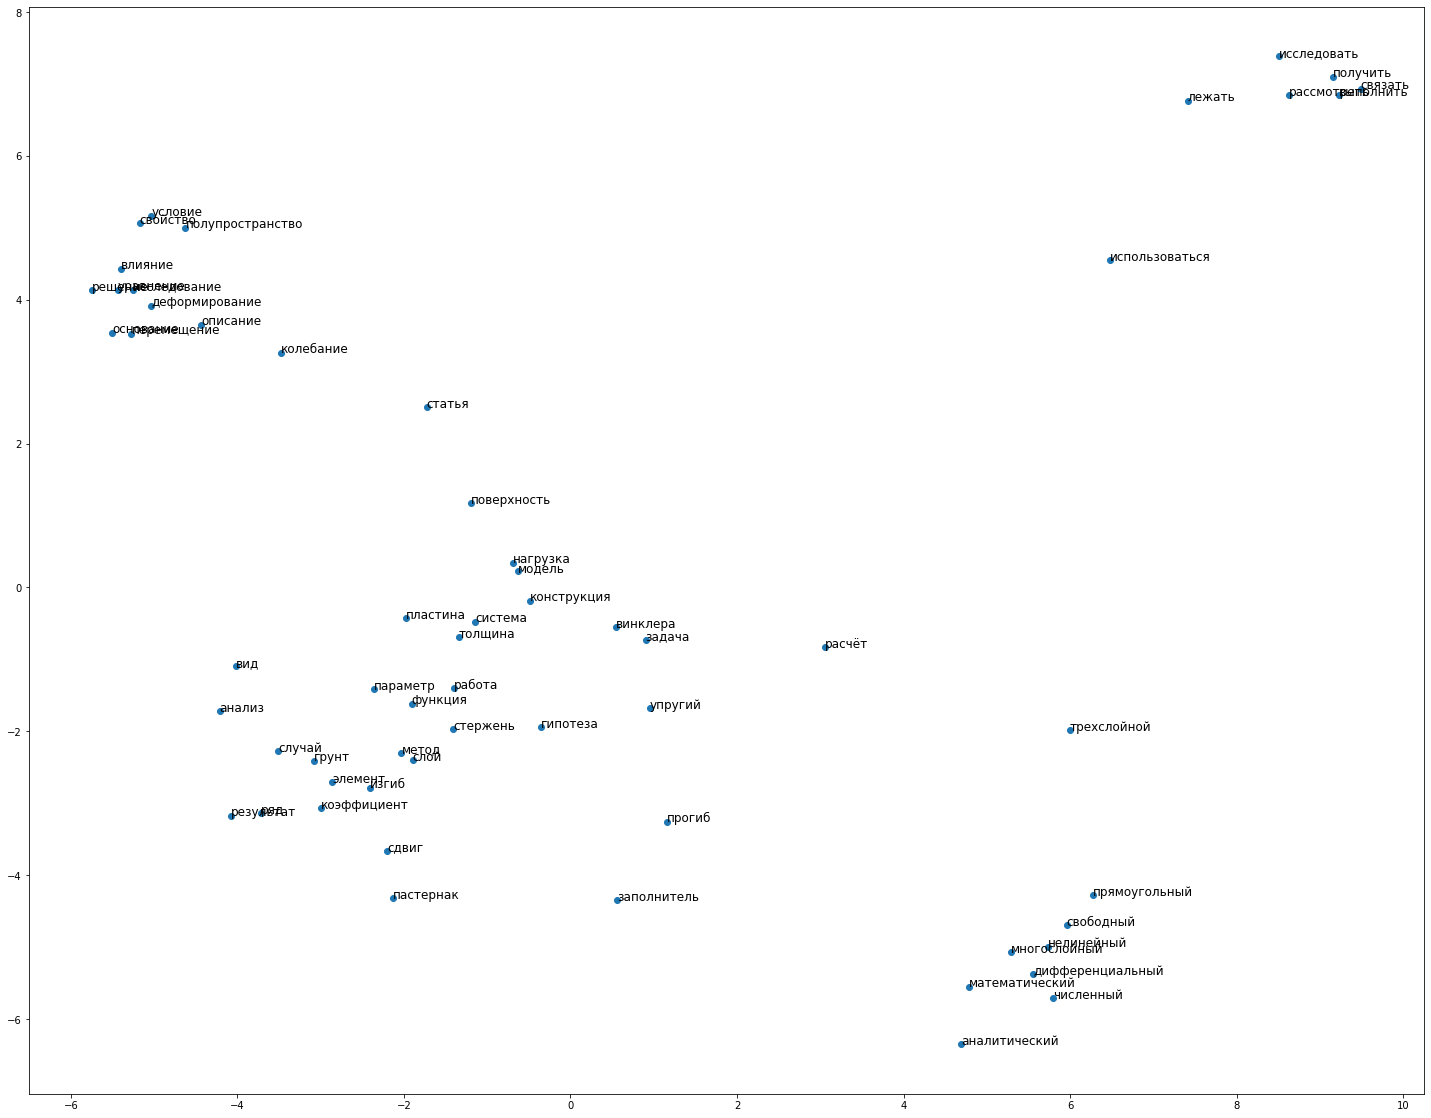

In [16]:
plt.figure(figsize=(25,20))
plt.scatter(word_vecs_2d[:,0], word_vecs_2d[:,1])

for word, coord in zip(words, word_vecs_2d):
    x, y = coord
    plt.text(x, y, word, size=12)

plt.show()

### Метод TfidfVectorizer

In [17]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(count_words)

feature_names = vectorizer.get_feature_names()
df = pd.DataFrame(vectors.toarray(), columns=feature_names)

print('Размерность матрицы TF-IDF: '
      '{}.'.format(df.shape))

Размерность матрицы TF-IDF: (926, 852).


C:\Users\37533\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [18]:
df

,abaqus,allam,arefi,dastjerdi,jabbarzadeh,kerr,kumar,kutlu,lal,li,...,экспериментальный,экспоненциальный,электрический,элемент,эрингена,эффект,являться,ядро,яровая,яхно
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
len(count_words)

926

In [22]:
X = scale(df.values)
pca = PCA(n_components=(851))
pca.fit(X)
# доля от общей дисперсии
var = pca.explained_variance_ratio_  #Процентная дисперсия, объясненная каждым из выбранных компонентов.
var1 = np.cumsum(np.round(var, decimals=5)*100) #

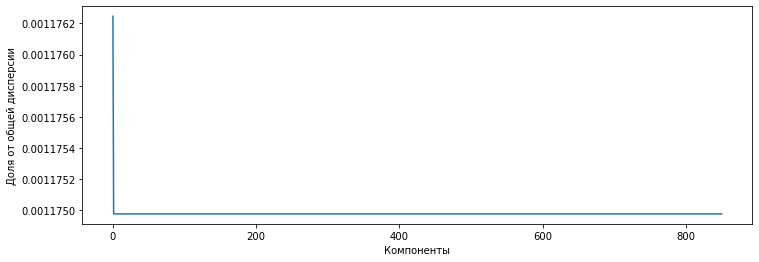

In [23]:
plt.figure(figsize=(12,4))
plt.plot(var)
plt.xlabel('Компоненты', fontsize=10)
plt.ylabel('Доля от общей дисперсии', fontsize=10);

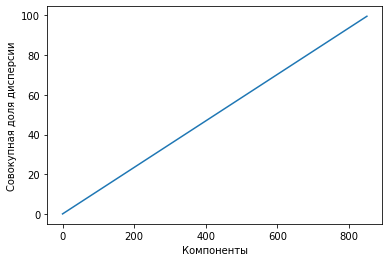

In [24]:
plt.figure(figsize=(6,4))
plt.plot(var1)
plt.xlabel('Компоненты', fontsize=10)
plt.ylabel('Совокупная доля дисперсии', fontsize=10);

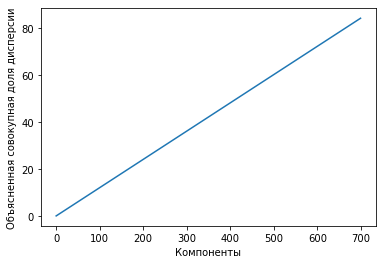

In [27]:
pca = PCA(n_components=700)
pca.fit(X)
var = pca.explained_variance_ratio_
var1 = np.cumsum(np.round(var, decimals=4)*100)

plt.plot(var1)
plt.xlabel('Компоненты', fontsize=10)
plt.ylabel('Объясненная совокупная доля дисперсии', fontsize=10);

In [26]:
gc.collect() 

15761